In [1]:
import numpy as np
from tqdm import tqdm
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

gpu = True
if gpu:
    import sigkernel as ksig
else:
    import sigkernel_cpu as ksig

from utils.transformations import *

# Setup parameters and kernel choice

In [2]:
# X_seed=None
# Y_seed=None
X_seed=1
Y_seed=8
initial_value = 1.0

num_permutations = 10000
n_levels = 4
n_samples = 100
sample_len = 60
dt = 1 / 252
percentile = 0.95
difference = True # parameter for the signature kernel which should be True for correct signature computation

# transformations which are done in sequence as below
cumsum = False # whether to transform the data to cumulative sum series
leadlag = False # whether to transform the data to lead-lag series
time_dimension = True # whether to add time dimension to the data

In [3]:
# static_kernel = ksig.static.kernels.LinearKernel()
static_kernel = ksig.static.kernels.RBFKernel(lengthscale=0.2)
# static_kernel = ksig.static.kernels.PolynomialKernel(degree=1)

# Generate Data

In [4]:
X = ksig.tests.gen_GBM_path(mu=0.1, sigma=0.2, dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
# Y = ksig.tests.gen_GBM_path(0.1, 0.3, dt, n_samples, sample_len, seed=Y_seed).astype(np.float32) * initial_value
Y = ksig.tests.gen_Heston_path(mu=0.1, v0=0.04, kappa=0.1, theta=0.04, sigma=0.2, rho=-0.5,
                               dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
# Y = ksig.tests.gen_OU_path(kappa=1.0, theta=1.0, sigma=0.2,
#                                dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value

### Transform

In [5]:
log_X = np.log(X)
log_Y = np.log(Y)

if cumsum:
    X = X.cumsum(axis=1)
    Y = Y.cumsum(axis=1)
    log_X = log_X.cumsum(axis=1)
    log_Y = log_Y.cumsum(axis=1)

if leadlag:
    X = lead_lag_transformation(X)
    Y = lead_lag_transformation(Y)
    log_X = lead_lag_transformation(log_X)
    log_Y = lead_lag_transformation(log_Y)

if time_dimension:
    t = np.linspace(0, dt * sample_len, sample_len).reshape(1,-1, 1).repeat(n_samples, axis=0)
    X = np.concatenate([t, X], axis=-1)
    Y = np.concatenate([t, Y], axis=-1)
    log_X = np.concatenate([t, log_X], axis=-1)
    log_Y = np.concatenate([t, log_Y], axis=-1)

X.shape, Y.shape, log_X.shape, log_Y.shape

((100, 119, 2), (100, 119, 2), (100, 119, 2), (100, 119, 2))

### Plots

(0.6850487202405929, 1.3085597813129426)

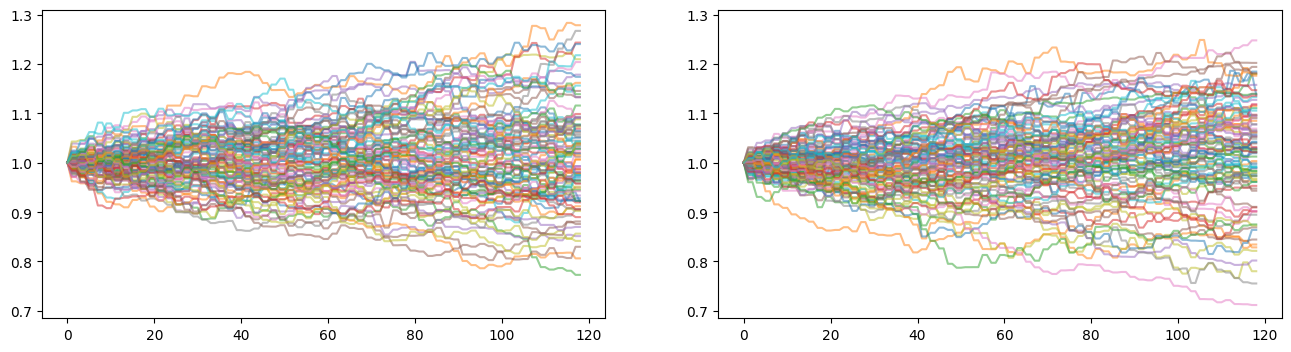

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(X[:,:,-1].squeeze().T, alpha=0.5);
ax[1].plot(Y[:,:,-1].squeeze().T, alpha=0.5);
ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)

(-0.3679365299642086, 0.2745831340551376)

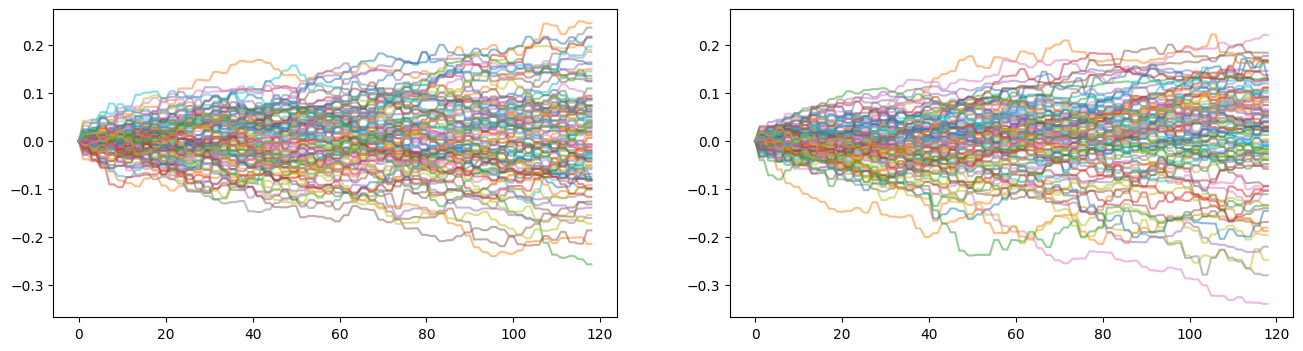

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(log_X[:,:,-1].squeeze().T, alpha=0.5);
ax[1].plot(log_Y[:,:,-1].squeeze().T, alpha=0.5);
ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)

### Statistics

In [8]:
print(log_X[:,:,-1].shape, log_Y[:,:,-1].shape)
print(f'Mean: {np.mean(np.diff(log_X[:,:,-1], axis=-1))/dt} / {np.mean(np.diff(log_Y[:,:,-1], axis=-1))/dt}')
print(f'Variance: {(np.var(np.diff(log_X[:,:,-1], axis=-1))/dt)**0.5} / {(np.var(np.diff(log_Y[:,:,-1], axis=-1))/dt)**0.5}')

(100, 119) (100, 119)
Mean: 0.025576330051990226 / 0.03346979693742469
Variance: 0.14170079269001692 / 0.14316787717897


# MMD Two Sample Test

### Permutation Test

Mean of permutat but doesion statistics: 1.594194639617372e-05


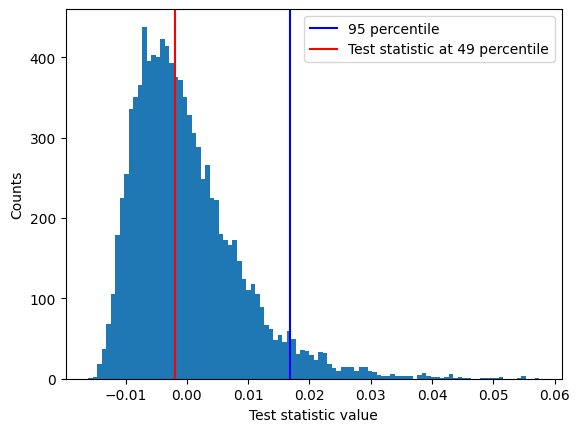

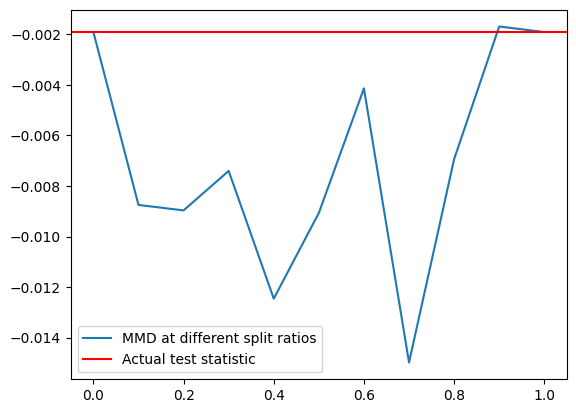

In [9]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, percentile=percentile)
print(f'Mean of permutat but doesion statistics: {np.mean(null_mmd)}')

In [10]:
idx = np.full((X.shape[1]), False)
idx[0] = True
idx[-1] = True
X[:,idx,:].shape

(100, 2, 2)

Mean of permutation statistics: 0.0001638323292548467


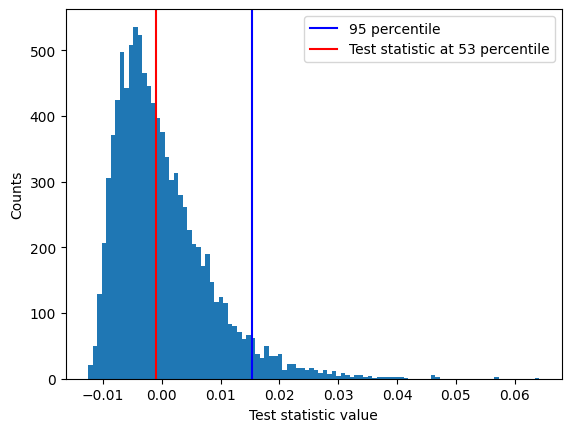

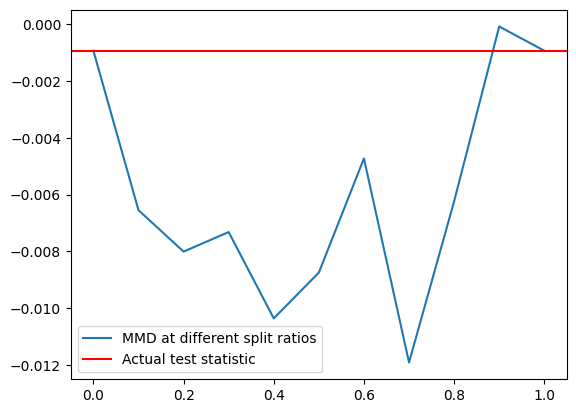

In [11]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X[:,idx,:], Y[:,idx,:], n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, percentile=percentile)
print(f'Mean of permutation statistics: {np.mean(null_mmd)}')

### Log of X and Y

Mean of permutation statistics: -3.6354996810668314e-05


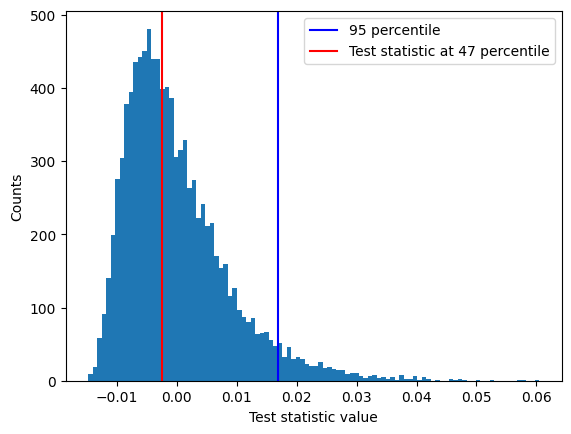

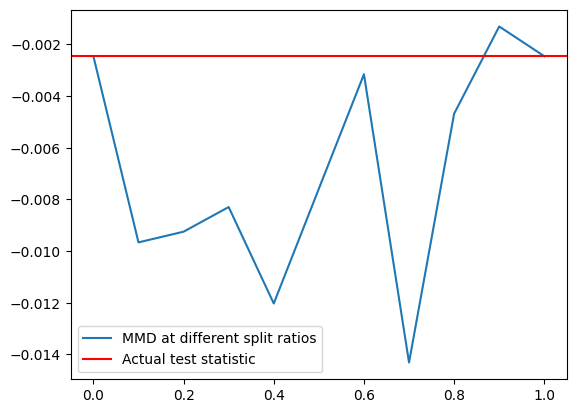

In [12]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(log_X, log_Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, percentile=percentile)
print(f'Mean of permutation statistics: {np.mean(null_mmd)}')

# Multiple runs

In [1]:
import numpy as np
from tqdm import tqdm
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

gpu = False
if gpu:
    import sigkernel as ksig
else:
    import sigkernel_cpu as ksig

from utils.transformations import *

In [2]:
def savefig(path):
    plt.savefig(path)
    plt.clf()
    plt.close()

def plot_and_save_paths(path, X, Y):
    _, ax = plt.subplots(1, 2, figsize=(16, 12))
    ax[0].plot(X.squeeze().T, alpha=0.5);
    ax[1].plot(Y.squeeze().T, alpha=0.5);
    ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    savefig(path)

def mmd_test_and_plot(p_suffix, param_name, param_value, n_samples, X, Y, n_levels, static_kernel, kernel_name, num_permutations=10000,
                      log=False, cumsum=False, leadlag=False, time_dimension=False):
    data_suffix = ''
    if log: data_suffix += '_log'
    if cumsum: data_suffix += '_cumsum'
    if leadlag: data_suffix += '_leadlag'
    if time_dimension: data_suffix += '_timedim'

    mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations, stats_plot=False)
    savefig(f'./figures/{param_name}/splits/{p_suffix}_{param_name}_{param_value}_ratio{data_suffix}_{kernel_name}_level_{n_levels}_{n_samples}_samples.png')
    ksig.tests.plot_permutation_samples(null_mmd, mmd_XY)
    savefig(f'./figures/{param_name}/{p_suffix}_{param_name}_{param_value}_quantile{data_suffix}_{kernel_name}_level_{n_levels}_{n_samples}_samples.png')

In [3]:
# mus = [0.05, 0.1, 0.15, 0.2]
# sigmas = [0.1, 0.2, 0.3, 0.4]

# # period = ['daily', 'daily', 'weekly', 'monthly']
# # lens = [30, 60, 52, 12]
# # samples = [200, 100, 100, 100]
# # sub_sample = [False, False, True, True]
# # period_dt = [252, 252, 52, 12]
# # sub_size = 10

# period = ['daily']
# lens = [60]
# samples = [100]
# sub_sample = [False]
# period_dt = [252]
# sub_size = 10

# upper_level_limit = 4
# kernel_name = ['linear', 'rbf0.5', 'rbf0.2']
# kernels = [ksig.static.kernels.LinearKernel(), ksig.static.kernels.RBFKernel(lengthscale=0.5), ksig.static.kernels.RBFKernel(lengthscale=0.2)]

# X_seed=1
# Y_seed=8
# initial_value = 1.0

# for i, t in enumerate(period_dt):
#     # parameters of experiment
#     p_suffix = period[i]
#     dt = 1 / t
#     sample_len = lens[i]
#     n_samples = samples[i]
#     t = np.linspace(0, dt * sample_len, sample_len).reshape(1,-1, 1).repeat(n_samples, axis=0)

#     # Generate data and transformations of first sample
#     X = ksig.tests.gen_GBM_path(mu=0.1, sigma=0.2, dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
#     log_X = np.log(X)
#     leadlag_X = lead_lag_transformation(X)
#     leadlag_log_X = lead_lag_transformation(log_X)
#     csll_X = lead_lag_transformation(X.cumsum(axis=1))
#     csll_log_X = lead_lag_transformation(log_X.cumsum(axis=1))
#     X_t = np.concatenate([t, X], axis=-1)
#     log_X_t = np.concatenate([t, log_X], axis=-1)

#     # vary mu
#     for mu in mus:
#         # Generate data and transformations of second sample
#         # Y = ksig.tests.gen_GBM_path(mu, 0.2, dt, n_samples, sample_len, seed=Y_seed).astype(np.float32) * initial_value
#         Y = ksig.tests.gen_Heston_path(mu=mu, v0=0.04, kappa=0.1, theta=0.04, sigma=0.2, rho=-0.5,
#                                        dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
#         log_Y = np.log(Y)
#         leadlag_Y = lead_lag_transformation(Y)
#         leadlag_log_Y = lead_lag_transformation(log_Y)
#         csll_log_Y = lead_lag_transformation(log_Y.cumsum(axis=1))
#         csll_Y = lead_lag_transformation(Y.cumsum(axis=1))
#         Y_t = np.concatenate([t, Y], axis=-1)
#         log_Y_t = np.concatenate([t, log_Y], axis=-1)

#         # save plots of paths
#         plot_and_save_paths(f'./figures/mu/path plots/{p_suffix}_mu_{mu}_paths_{n_samples}_samples.png', X, Y)
#         plot_and_save_paths(f'./figures/mu/path plots/{p_suffix}_mu_{mu}_paths_log_{n_samples}_samples.png', log_X, log_Y)

#         # perform experiments
#         for j, static_kernel in enumerate(kernels):

#             for n_levels in range(2, upper_level_limit+1):
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, X, Y, n_levels, static_kernel, kernel_name[j])
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, log_X, log_Y, n_levels, static_kernel, kernel_name[j], log=True)
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, leadlag_X, leadlag_Y, n_levels, static_kernel, kernel_name[j], leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, leadlag_log_X, leadlag_log_Y, n_levels, static_kernel, kernel_name[j], log=True, leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, csll_X, csll_Y, n_levels, static_kernel, kernel_name[j], cumsum=True, leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, csll_log_X, csll_log_Y, n_levels, static_kernel, kernel_name[j], log=True, cumsum=True, leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, X_t, Y_t, n_levels, static_kernel, kernel_name[j], time_dimension=True)
#                 mmd_test_and_plot(p_suffix, 'mu', mu, n_samples, log_X_t, log_Y_t, n_levels, static_kernel, kernel_name[j], log=True, time_dimension=True)

#                 if sub_sample[i]:
#                     mmd_test_and_plot(p_suffix, 'mu', mu, sub_size, X[:sub_size], Y[:sub_size], n_levels, static_kernel, kernel_name[j])
#                     mmd_test_and_plot(p_suffix, 'mu', mu, sub_size, log_X[:sub_size], log_Y[:sub_size], n_levels, static_kernel, kernel_name[j], log=True)

#     # vary sigma
#     for sigma in sigmas:
#         # Y = ksig.tests.gen_GBM_path(0.1, sigma, dt, n_samples, sample_len, seed=Y_seed).astype(np.float32) * initial_value
#         Y = ksig.tests.gen_Heston_path(mu=0.1, v0=sigma**2, kappa=0.1, theta=sigma**2, sigma=0.2, rho=-0.5,
#                                        dt=dt, n_paths=n_samples, seq_len=sample_len, seed=X_seed).astype(np.float32) * initial_value
#         log_Y = np.log(Y)
#         leadlag_Y = lead_lag_transformation(Y)
#         leadlag_log_Y = lead_lag_transformation(log_Y)
#         csll_log_Y = lead_lag_transformation(log_Y.cumsum(axis=1))
#         csll_Y = lead_lag_transformation(Y.cumsum(axis=1))
#         Y_t = np.concatenate([t, Y], axis=-1)
#         log_Y_t = np.concatenate([t, log_Y], axis=-1)
#         plot_and_save_paths(f'./figures/sigma/path plots/{p_suffix}_sigma_{sigma}_paths_{n_samples}_samples.png', X, Y)
#         plot_and_save_paths(f'./figures/sigma/path plots/{p_suffix}_sigma_{sigma}_paths_log_{n_samples}_samples.png', log_X, log_Y)

#         for j, static_kernel in enumerate(kernels):

#             for n_levels in range(2, upper_level_limit+1):
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, X, Y, n_levels, static_kernel, kernel_name[j])
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, log_X, log_Y, n_levels, static_kernel, kernel_name[j], log=True)
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, leadlag_X, leadlag_Y, n_levels, static_kernel, kernel_name[j], leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, leadlag_log_X, leadlag_log_Y, n_levels, static_kernel, kernel_name[j], log=True, leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, csll_X, csll_Y, n_levels, static_kernel, kernel_name[j], cumsum=True, leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, csll_log_X, csll_log_Y, n_levels, static_kernel, kernel_name[j], log=True, cumsum=True, leadlag=True)
#                 mmd_test_and_plot(p_suffix, 'sigma', sigma, n_samples, X_t, Y_t, n_levels, static_kernel, kernel_name[j], time_dimension=True)

#                 if sub_sample[i]:
#                     mmd_test_and_plot(p_suffix, 'sigma', sigma, sub_size, X[:sub_size], Y[:sub_size], n_levels, static_kernel, kernel_name[j])
#                     mmd_test_and_plot(p_suffix, 'sigma', sigma, sub_size, log_X[:sub_size], log_Y[:sub_size], n_levels, static_kernel, kernel_name[j], log=True)